# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?"

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          |
|------------------------|:-------------------|
|Administrative          | Quantidade de acessos em páginas administrativas|
|Administrative_Duration | Tempo de acesso em páginas administrativas |
|Informational           | Quantidade de acessos em páginas informativas  |
|Informational_Duration  | Tempo de acesso em páginas informativas  |
|ProductRelated          | Quantidade de acessos em páginas de produtos |
|ProductRelated_Duration | Tempo de acesso em páginas de produtos |
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  |
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações |
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico |
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) |
|Month                   | Mês  |
|OperatingSystems        | Sistema operacional do visitante |
|Browser                 | Browser do visitante |
|Region                  | Região |
|TrafficType             | Tipo de tráfego                  |
|VisitorType             | Tipo de visitante: novo ou recorrente |
|Weekend                 | Indica final de semana |
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

import scipy.cluster.hierarchy as shc

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from gower import gower_matrix

In [29]:
df = pd.read_csv('/content/online_shoppers_intention.csv')

In [30]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [31]:
df.Revenue.value_counts(dropna=False)

,count
Revenue,
False,10422
True,1908


## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [32]:
len(df.columns)

18

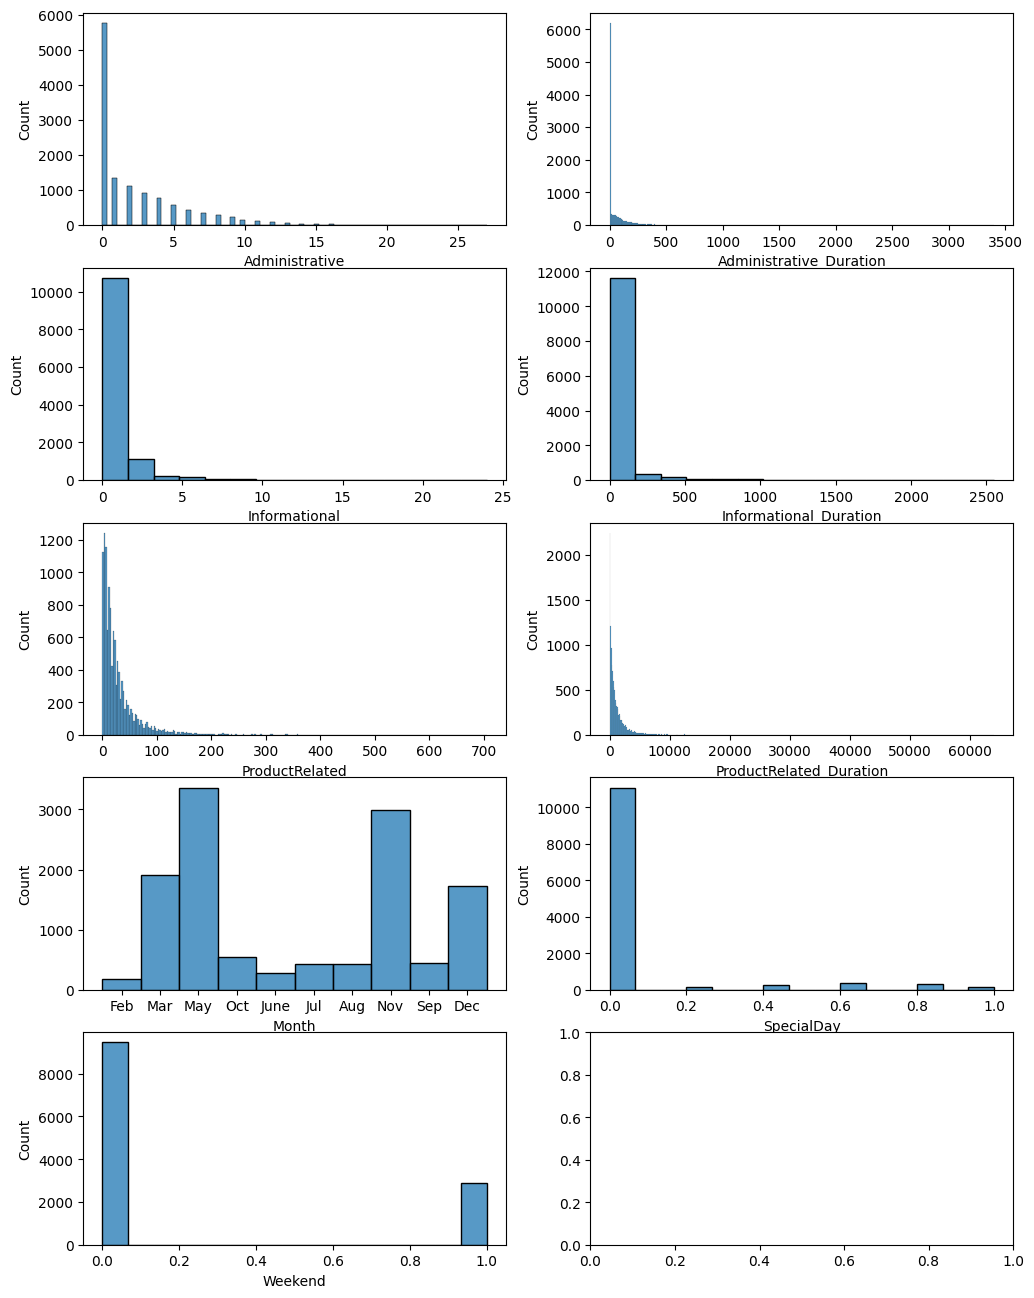

In [63]:
# cria um histograma para cada variável da lista variaveis
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 16))
variaveis = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
        'Month', 'SpecialDay', 'Weekend']
for i, var in enumerate(variaveis):
    sns.histplot(ax=axes[i//2][i%2], x=df[var])

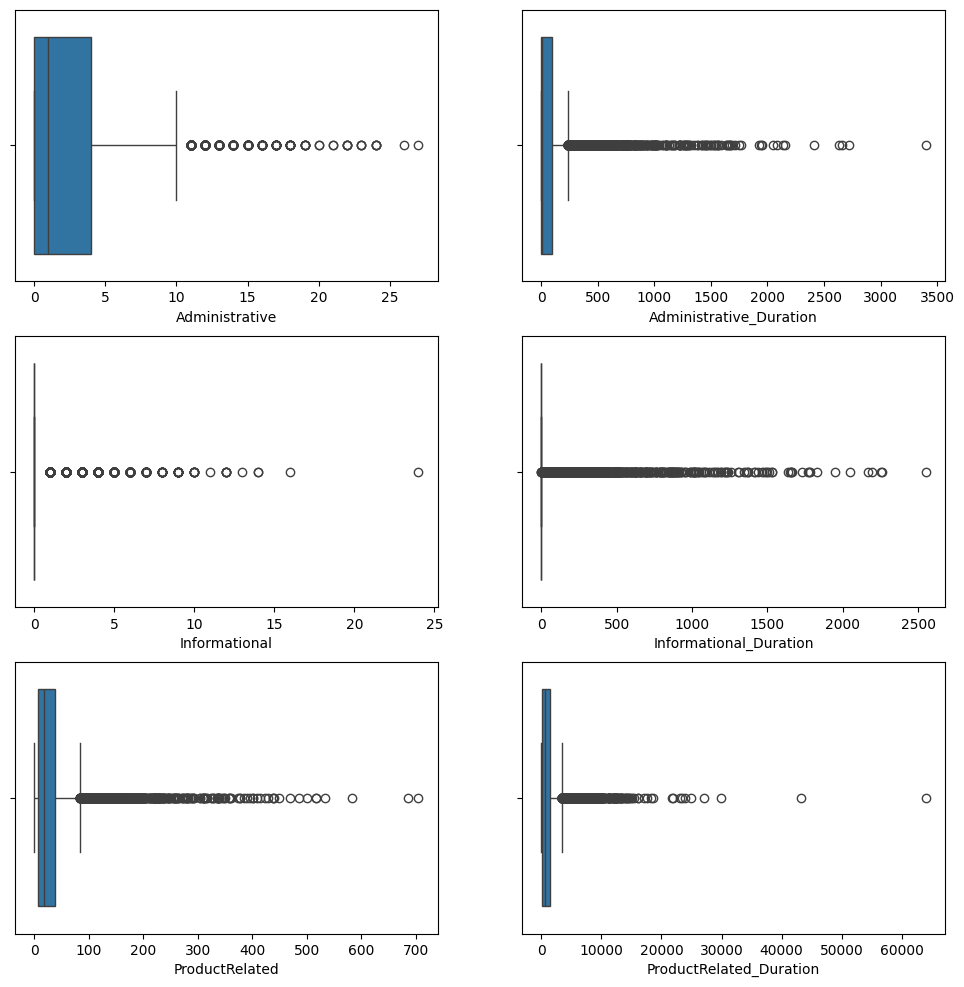

In [34]:
# cria um Boxplot para cada variável da lista variaveis
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

for i, var in enumerate(variaveis[:6]):
    sns.boxplot(ax=axes[i//2][i%2], x=df[var])

In [35]:
# exibe a contagem de valores nulos e não nulos,itera pelos resultados de contagem e mostra a contage de False
for var in variaveis:
    print(f"{var}")
    count_na = df[var].isna().value_counts()
    for index, value in count_na.items():
        print(f"{index}: {value}")
    print()

Administrative
False: 12330

Administrative_Duration
False: 12330

Informational
False: 12330

Informational_Duration
False: 12330

ProductRelated
False: 12330

ProductRelated_Duration
False: 12330



In [36]:
#Calcula o Q1, Q3, e o IQR para cada variável, define o limite superior para os outliers e conta quantos desses valores existem.
for var in variaveis:
    q1 = df[var].quantile(q=0.25)
    q3 = df[var].quantile(q=0.75)
    iqr = q3 - q1
    outliers_cut = q3 + (1.5 * iqr)
    num_outliers = df.query(f"{var} > @outliers_cut").shape[0]

    print(f"{var}")
    print(f"Ponto de corte para outliers: {outliers_cut}")
    print(f"3º quartil: {q3}")
    print(f"Número de outliers: {num_outliers}")
    print()

Administrative
Ponto de corte para outliers: 10.0
3º quartil: 4.0
Número de outliers: 404

Administrative_Duration
Ponto de corte para outliers: 233.14062499999997
3º quartil: 93.25625
Número de outliers: 1172

Informational
Ponto de corte para outliers: 0.0
3º quartil: 0.0
Número de outliers: 2631

Informational_Duration
Ponto de corte para outliers: 0.0
3º quartil: 0.0
Número de outliers: 2405

ProductRelated
Ponto de corte para outliers: 84.5
3º quartil: 38.0
Número de outliers: 987

ProductRelated_Duration
Ponto de corte para outliers: 3384.1867837500004
3º quartil: 1464.1572135000001
Número de outliers: 961



## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [39]:
new_df = df[variaveis].copy()

In [70]:
# Tratar variáveis qualitativas e valores faltantes
new_df = pd.get_dummies(new_df.dropna())
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 578.1 KB


In [64]:
#criar uma máscara booleana (cate_mask) para identificar as colunas categóricas no DataFrame
vars_cate = new_df.select_dtypes(exclude=["int64", "float64"])
cate_mask = [True if x in vars_cate.columns else False for x in new_df.columns]
cate_mask

[False, False, False, False, False, False]

In [71]:
# Padronizando as variáveis numéricas com "StandardScaler" e mantendo as variáveis categóricas separadas
num_mask = np.invert(cate_mask)
std = StandardScaler()
df_num = std.fit_transform(new_df.loc[:, num_mask])
df_num = pd.DataFrame(df_num, index=new_df.index, columns=new_df.loc[:, num_mask].columns)

df_cate = new_df.loc[:, cate_mask]

In [72]:
#combinar as variáveis numéricas padronizadas (df_num) com as variáveis categóricas (df_cate) em um único df
df_num.index.name = 'id'
new_df.index.name = 'id'

merged_df = df_num.merge(df_cate, how='left', on="id")
merged_df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
id,,,,,,
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430
...,...,...,...,...,...,...
12325,0.206173,0.363075,-0.396478,-0.244931,0.478227,0.307822
12326,-0.696993,-0.457191,-0.396478,-0.244931,-0.601062,-0.380957
12327,-0.696993,-0.457191,-0.396478,-0.244931,-0.578577,-0.528063


## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa.

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final.
- Se puder, sugira nomes para os grupos.

In [73]:
#Calcula-se a matriz de distâncias de Gower
distancia_gower = gower_matrix(merged_df, cat_features=cate_mask)
distancia_gower[:5, :5]

array([[0.        , 0.00040314, 0.        , 0.00024335, 0.00376245],
       [0.00040314, 0.        , 0.00040314, 0.00015979, 0.00335931],
       [0.        , 0.00040314, 0.        , 0.00024335, 0.00376245],
       [0.00024335, 0.00015979, 0.00024335, 0.        , 0.0035191 ],
       [0.00376245, 0.00335931, 0.00376245, 0.0035191 , 0.        ]],
      dtype=float32)

In [46]:
#Converte a matriz de distâncias em vetor
gdv = squareform(distancia_gower,force='tovector')

In [47]:
#algoritmo de linkage hierárquico para formar clusters
Z = linkage(gdv, method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df.head()

,id1,id2,dist,n
0,0.0,2.0,0.0,2.0
1,6.0,12330.0,0.0,3.0
2,2734.0,2753.0,0.0,2.0
3,4008.0,12332.0,0.0,3.0
4,12118.0,12333.0,0.0,4.0


In [74]:

grupos_3 = fcluster(Z, 3, criterion='maxclust')
grupos_4 = fcluster(Z, 4, criterion='maxclust')
df['3_grupos'] = grupos_3
df['4_grupos'] = grupos_4
df['4_grupos'].value_counts()

,count
4_grupos,
4,6202
2,6015
3,110
1,3


<Axes: xlabel='Administrative_Duration', ylabel='4_grupos'>

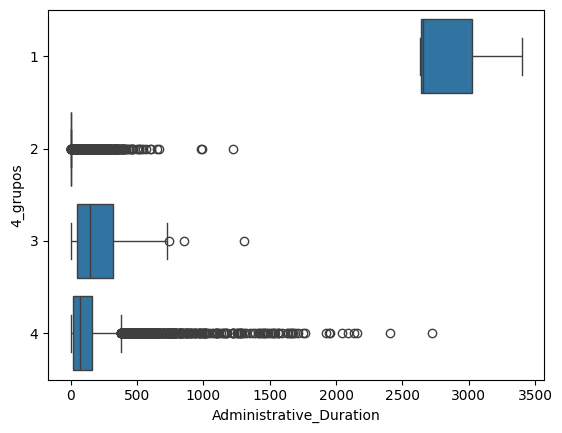

In [51]:
sns.boxplot(data=df, y='4_grupos', x=variaveis[1], orient='h')

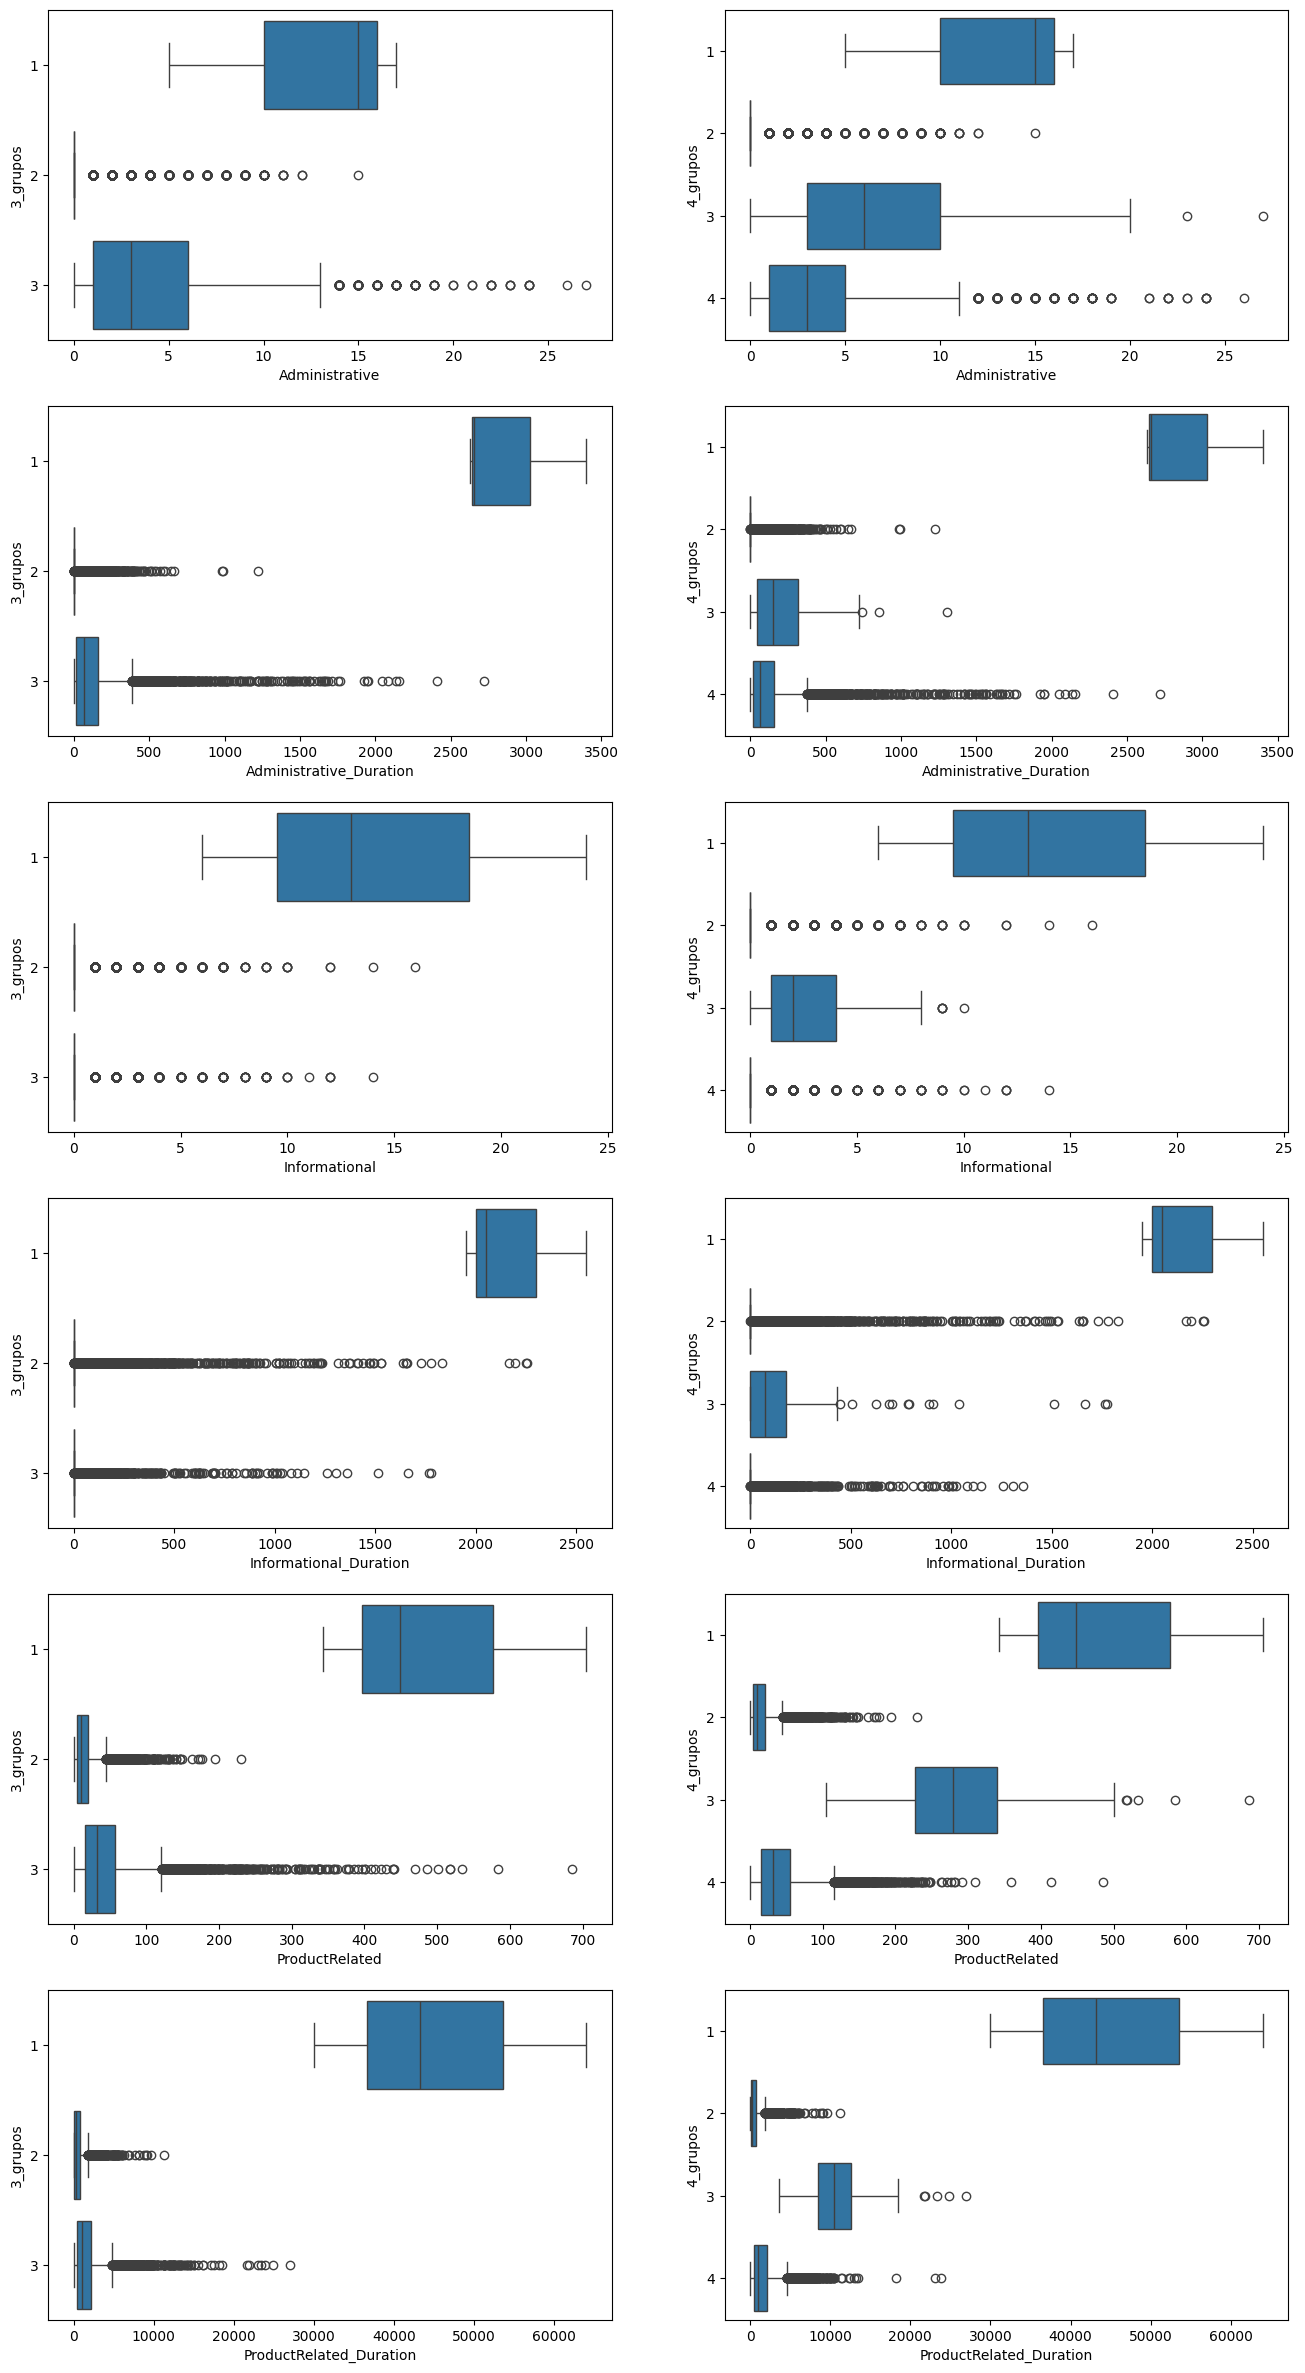

In [52]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(16, 30))
grupos = ["3_grupos", "4_grupos"]
for i in range(12):
    sns.boxplot(data=df, ax=axes[i//2][i%2], y=grupos[i%2], x=variaveis[i//2], orient='h')


<Axes: xlabel='4_grupos'>

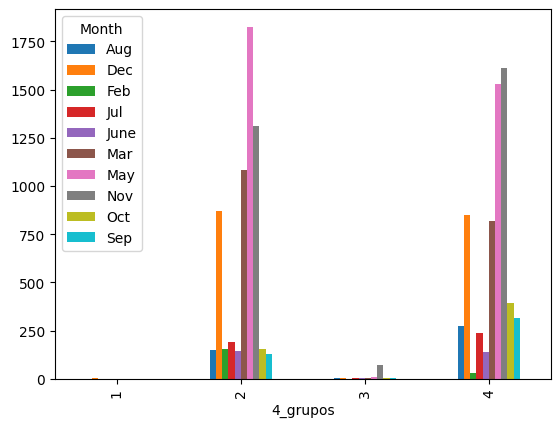

In [53]:
df.groupby(['4_grupos', 'Month'])['Month'].count().unstack().plot.bar()



In [54]:
df.groupby(['4_grupos', 'Weekend'])['Weekend'].count()

4_grupos  Weekend
1         False         2
          True          1
2         False      4670
          True       1345
3         False        81
          True         29
4         False      4709
          True       1493
Name: Weekend, dtype: int64

<Axes: xlabel='3_grupos'>

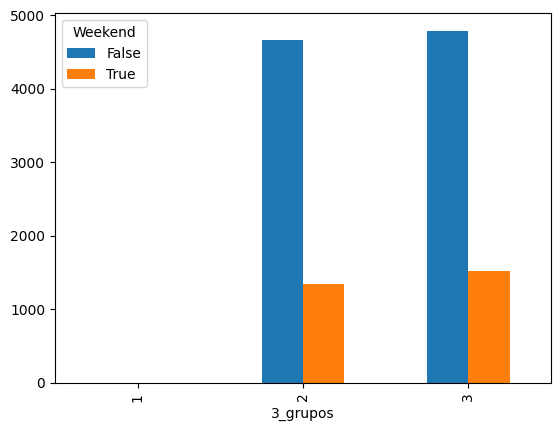

In [55]:
df.groupby(['3_grupos', 'Weekend'])['Weekend'].count().unstack().plot.bar()

<Axes: xlabel='4_grupos'>

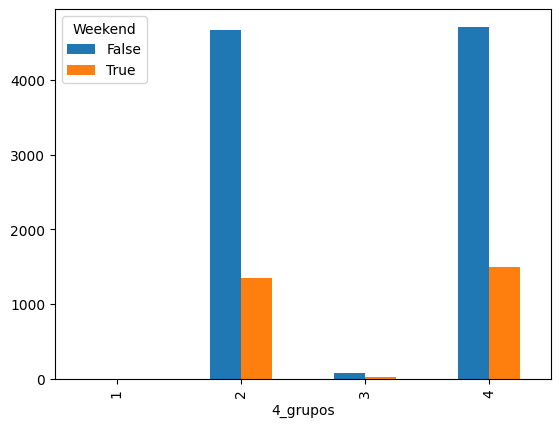

In [56]:
df.groupby(['4_grupos', 'Weekend'])['Weekend'].count().unstack().plot.bar()

**Comentário:** Ao analisar as variáveis quantitativas podemos ver com com 4 grupos o grupo 4 e o grupo 2 ficam parecidos, o que poderia indicar que não vale a pena trabalhar com 4 grupos. Mas ao observarmos o comportamento com as variáveis categóricas, vemos que o grupo 4 e o grupo 2 são diferentes. Portanto, a classificação em 4 grupos parece a melhor opção.

In [57]:
pd.crosstab(df['VisitorType'], df['3_grupos'])

3_grupos,1,2,3
VisitorType,,,
New_Visitor,0,613,1081
Other,0,53,32
Returning_Visitor,3,5349,5199


In [58]:
pd.crosstab(df['VisitorType'], df['4_grupos'])

4_grupos,1,2,3,4
VisitorType,,,,
New_Visitor,0,613,1,1080
Other,0,53,0,32
Returning_Visitor,3,5349,109,5090


In [59]:
pd.crosstab(df['Revenue'], df['3_grupos'])

3_grupos,1,2,3
Revenue,,,
False,3,5382,5037
True,0,633,1275


In [60]:
pd.crosstab(df['Revenue'], df['4_grupos'])

4_grupos,1,2,3,4
Revenue,,,,
False,3,5382,72,4965
True,0,633,38,1237


## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*).
- Qual grupo possui clientes mais propensos à compra?

In [61]:
cross_df = pd.crosstab(df['Revenue'], df['3_grupos'])
cross_df.reset_index(inplace=True)
cross_df

3_grupos,Revenue,1,2,3
0,False,3,5382,5037
1,True,0,633,1275


**Comentário:** O grupo 2